## Data Description

Here's the data description provided for this dataset. There is no data dictionary in order to avoid leaking user information.

### Transaction Dataframe

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R_) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

**Categorical Features**

- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

### Identity Dataframe

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)


**Categorical Features**

- DeviceType
- DeviceInfo
- id_12 - id_38

#### Importing libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import time

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re

In [3]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

In [4]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [5]:
#path = "/content/drive/MyDrive/Colab_Notebooks/IEEE fraud detection/"
path = ""

Let's read the two dataframes from the disk.

In [6]:
#Reading the train identity dataframe
df_train_id = pd.read_csv(path + "train_identity.csv")

In [7]:
#Reading the train transaction dataframe
df_train_tran = pd.read_csv(path + "train_transaction.csv")

In [8]:
#Changing pandas settings to display all the columns in the dataframe
pd.set_option('display.max_columns', None)

In [9]:
df_train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [10]:
df_train_tran.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [11]:
df_train_id.shape

(144233, 41)

In [12]:
df_train_tran.shape

(590540, 394)

The transactions dataset appears to be huge.

Let's check the datatypes of columns and the number of null values in each column.

In [13]:
df_train_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [14]:
#Setting verbose and null_counts to True as the info() method won't display the details we need by default for such a large dataframe

df_train_tran.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 394 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int64  
 1   isFraud         590540 non-null  int64  
 2   TransactionDT   590540 non-null  int64  
 3   TransactionAmt  590540 non-null  float64
 4   ProductCD       590540 non-null  object 
 5   card1           590540 non-null  int64  
 6   card2           581607 non-null  float64
 7   card3           588975 non-null  float64
 8   card4           588963 non-null  object 
 9   card5           586281 non-null  float64
 10  card6           588969 non-null  object 
 11  addr1           524834 non-null  float64
 12  addr2           524834 non-null  float64
 13  dist1           238269 non-null  float64
 14  dist2           37627 non-null   float64
 15  P_emaildomain   496084 non-null  object 
 16  R_emaildomain   137291 non-null  object 
 17  C1       

As we expected, the transaction dataset is very large and takes up 1.7 GB. We can reduce the memory usage by converting 64-bit columns into 32-bit or 16-bit. Let's do this after merging the two dataframes.

### Merging the two dataframes

Let's merge the two dataframes on their identity column: TransactionID

In [15]:
#Checking the number of unique transaction IDs in the identity dataframe and comparing this to the number of rows in the df
print(df_train_id['TransactionID'].unique().shape[0])
print(df_train_id.shape[0])

144233
144233


In [16]:
#Doing the same for the transaction dataframe
print(df_train_tran['TransactionID'].unique().shape[0])
print(df_train_tran.shape[0])

590540
590540


The identity dataframe has fewer unique TransactionIDs than the transaction dataframe. Also, there are no repeated transaction IDs in either dataframe.

Since the transaction dataframe contains more than twice the number of rows that the identity dataframe has, let's retain those rows and add the columns of the identity dataframe wherever possible.

In [17]:
#Merging the two dataframes
train_df = pd.merge(df_train_id, df_train_tran, on="TransactionID", how='right')

In [18]:
train_df.shape

(590540, 434)

The number of rows in 590540, the same number that we had in the transaction dataframe.

In [19]:
#Deleting the initial dataframes

del df_train_id, df_train_tran

In [20]:
#Triggering garbage collection

gc.collect()

247

### Reducing Memory Usage

Let's check the memory usage of the merged train dataframe.

In [21]:
print("Train set: {:4.2f} Mb".format(train_df.memory_usage().sum() / 1024**2))

Train set: 1959.88 Mb


Since this dataframe contains close to 600,000 rows and over 400 columns, it occupies a lot of space in the memory.

Let's see if the memory usage of this dataframe can be reduced.

In [22]:
#Defining a function to convert columns to smaller sizes

def float_int_memory_reducer(df, verbose=True):
    
    #Let's reduce the datatype of columns to fewer bits whenever possible
    reduce_datatypes = ['int16', 'int32', 'int64', 'float32', 'float64']
    
    #Getting the inital size of the dataframe
    starting_memory = df.memory_usage().sum() / 1024**2
    
    #Looping through the columns of the dataframe
    for column in df.columns:
        
        column_type = df[column].dtypes
        
        #Checking if the column has a numerical datatype
        if column_type in reduce_datatypes:
            
            #Getting the maximum and minimum values in a column
            col_min = df[column].min()
            col_max = df[column].max()
            
            #Checking if the column is an integer type
            if str(column_type)[:3] == 'int':
                
                # We can use np.iinfo().max to find the maximum size for integer data types
                
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
            
            #Converting float-type columns
            else:
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[column] = df[column].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
    
    #Getting the final size of the dataframe after reductions
    ending_memory = df.memory_usage().sum() / 1024**2
    
    if verbose: 
        print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(ending_memory, 100 * (starting_memory - ending_memory) / starting_memory))
    
    return df

In [23]:
#Getting the time when the cell execution starts
start_process_time = time.time()

#Passing the dataframe to the function
train_df = float_int_memory_reducer(train_df)
print('Training set dimensions:', train_df.shape)

#Checking the time when cell execution ends
elapsed_time = time.time() - start_process_time
print(elapsed_time/60)

Memory usage decreased to 650.48 Mb (66.8% reduction)
Training set dimensions: (590540, 434)
0.8271602908770244


In [24]:
#Triggering garbage collection

gc.collect()

20

#### Repeating these steps (reading, merging, and reducing memory usage) for the test dataset

In [25]:
#Reading the test data from the csv files

df_test_id = pd.read_csv(path + "test_identity.csv")
df_test_tran = pd.read_csv(path + "test_transaction.csv")

print(df_test_id.shape)
print(df_test_tran.shape)

(141907, 41)
(506691, 393)


In [26]:
#Merging the two dataframes
test_df = pd.merge(df_test_id, df_test_tran, on="TransactionID", how='right')
test_df.shape

(506691, 433)

In [27]:
#Deleting the old dataframes

del df_test_id, df_test_tran

In [28]:
#Reducing the memory used by the combined dataframe

test_df = float_int_memory_reducer(test_df)
print('Test set dimensions: ', test_df.shape)

Memory usage decreased to 565.37 Mb (66.3% reduction)
Test set dimensions:  (506691, 433)


In [29]:
#Triggering garbage collection

gc.collect()

20

## Handling Missing Values

In [30]:
train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 434 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int32  
 1   id_01           144233 non-null  float16
 2   id_02           140872 non-null  float32
 3   id_03           66324 non-null   float16
 4   id_04           66324 non-null   float16
 5   id_05           136865 non-null  float16
 6   id_06           136865 non-null  float16
 7   id_07           5155 non-null    float16
 8   id_08           5155 non-null    float16
 9   id_09           74926 non-null   float16
 10  id_10           74926 non-null   float16
 11  id_11           140978 non-null  float16
 12  id_12           144233 non-null  object 
 13  id_13           127320 non-null  float16
 14  id_14           80044 non-null   float16
 15  id_15           140985 non-null  object 
 16  id_16           129340 non-null  object 
 17  id_17    

As we can see, there a lot of missing values. Let's check the percentage of missing values in each column.

In [31]:
#Changing pandas setting to display a maximum of 500 rows
pd.set_option('display.max_rows', 500)

In [32]:
#Checking the percentage of missing values in each column

(train_df.isnull().sum()*100/train_df.shape[0]).sort_values(ascending=False)

id_24             99.196159
id_25             99.130965
id_07             99.127070
id_08             99.127070
id_21             99.126393
id_26             99.125715
id_27             99.124699
id_23             99.124699
id_22             99.124699
dist2             93.628374
D7                93.409930
id_18             92.360721
D13               89.509263
D14               89.469469
D12               89.041047
id_04             88.768923
id_03             88.768923
D6                87.606767
id_33             87.589494
id_10             87.312290
D8                87.312290
id_09             87.312290
D9                87.312290
id_30             86.865411
id_32             86.861855
id_34             86.824771
id_14             86.445626
V157              86.123717
V162              86.123717
V139              86.123717
V138              86.123717
V155              86.123717
V149              86.123717
V141              86.123717
V148              86.123717
V147              86

In [33]:
#Storing the column names and their percentage of missing values in a new dataframe

missing_values_df = pd.DataFrame(train_df.isnull().sum()*100/train_df.shape[0])

In [34]:
missing_values_df.head()

,0
TransactionID,0.000000
id_01,75.576083
id_02,76.145223
id_03,88.768923
id_04,88.768923


This dataframe needs to be formatted.

In [35]:
#Storing the column names in a different column
missing_values_df['Column_name'] = missing_values_df.index

In [36]:
#Renaming column 0
missing_values_df.rename(columns = {0 : 'Percentage_missing'}, inplace=True)

In [37]:
#Resetting the index of the dataframe to have numerical values
missing_values_df = missing_values_df.reset_index(drop=True)

In [38]:
missing_values_df.head()

,Percentage_missing,Column_name
0,0.000000,TransactionID
1,75.576083,id_01
2,76.145223,id_02
3,88.768923,id_03
4,88.768923,id_04


In [39]:
#Rearranging the columns in the dataframe

missing_values_df = missing_values_df[['Column_name', 'Percentage_missing']]
missing_values_df.head()

,Column_name,Percentage_missing
0,TransactionID,0.000000
1,id_01,75.576083
2,id_02,76.145223
3,id_03,88.768923
4,id_04,88.768923


In [40]:
#Sorting the column names by their percentage of missing values

missing_values_df.sort_values(by='Percentage_missing', ascending=False)

,Column_name,Percentage_missing
24,id_24,99.196159
25,id_25,99.130965
7,id_07,99.127070
8,id_08,99.127070
21,id_21,99.126393
26,id_26,99.125715
27,id_27,99.124699
23,id_23,99.124699
22,id_22,99.124699
54,dist2,93.628374


There's a jump from 75.58% missing to 59.65% missing values, and a similar jump from 44.52% to 28.68%.

In [41]:
#Checking the number of columns that have 75% missing values or more
missing_values_df[missing_values_df['Percentage_missing']>= 75].shape[0]

208

In [42]:
#Checking the number of columns that have 40% missing values or more
missing_values_df[missing_values_df['Percentage_missing']>= 50].shape[0]

214

In [43]:
#Checking the number of columns that have 40% missing values or more
missing_values_df[missing_values_df['Percentage_missing']>= 40].shape[0]

232

In [44]:
#A reminder of the dimensions of the dataframe
train_df.shape

(590540, 434)

Since the difference between the number of columns that have 75% (or more) values missing and 40% (or more) values missing is 232 - 208 = 24 columns, let's go ahead and drop columns that have 40% missing values or more. This will mean dropping 232 columns.

In [45]:
#Removing the columns that have 40% missing values or more from this list
missing_values_df = missing_values_df[missing_values_df['Percentage_missing'] < 40]

In [46]:
#Sorting the column names by their percentage of missing values

missing_values_df.sort_values(by='Percentage_missing', ascending=False)

,Column_name,Percentage_missing
91,M6,28.678836
135,V41,28.612626
140,V46,28.612626
146,V52,28.612626
145,V51,28.612626
144,V50,28.612626
143,V49,28.612626
142,V48,28.612626
141,V47,28.612626
139,V45,28.612626


In [47]:
#Storing the names of the columns to be retained in a list

cols_to_retain = missing_values_df['Column_name'].tolist()

In [48]:
#Making a note of the columns that are being dropped (to make the same changes to the training set)
dropped_columns = list(set(train_df.columns) - set(cols_to_retain))

In [49]:
#Checking the number of columns that we're planning to drop

print(train_df.shape)
print(train_df[cols_to_retain].shape)

(590540, 434)
(590540, 202)


Dropping the columns that have 40% (or more) null values (i.e., dropping 232 columns)

In [50]:
train_df = train_df[cols_to_retain]
train_df.shape

(590540, 202)

We cannot drop any rows, as we need to provide a probability of fraud for all the rows of the test set.

In [51]:
#Deleting variables that are no longer required

del cols_to_retain

In [52]:
#Triggering garbage collection

gc.collect()

80

In [53]:
#Let's drop the TransactionID column, as that adds no value

train_df.drop(['TransactionID'], axis=1, inplace=True)

Since the TransactionID and probability of fraud are the two columns that need to be submitted, this column shouldn't be directly dropped from the test set.

In [54]:
train_df.head(10)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,0.0,T,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,T,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,315.0,F,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,94.0,84.0,111.0,F,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

#### Dropping columns in the test set

In [55]:
#Taking a look at the list of dropped columns

print(dropped_columns)

['V213', 'V322', 'V272', 'M8', 'V338', 'id_22', 'V236', 'V224', 'V260', 'V230', 'V188', 'V174', 'V327', 'V334', 'V145', 'R_emaildomain', 'V245', 'V178', 'V4', 'V156', 'V265', 'V250', 'V276', 'V164', 'V199', 'V209', 'V149', 'V263', 'id_09', 'V251', 'V274', 'V331', 'id_11', 'id_15', 'V221', 'V191', 'V147', 'V138', 'V208', 'V197', 'D12', 'V212', 'V216', 'V273', 'id_31', 'V215', 'V264', 'V207', 'V200', 'V189', 'V143', 'V179', 'V150', 'V142', 'id_36', 'V335', 'V231', 'V140', 'V144', 'V226', 'id_27', 'dist2', 'D9', 'V175', 'D7', 'V324', 'M5', 'V214', 'V255', 'V210', 'V247', 'id_24', 'V2', 'id_04', 'V246', 'V243', 'id_30', 'V159', 'V169', 'V241', 'V182', 'V163', 'V154', 'V184', 'V196', 'V239', 'V235', 'M3', 'V244', 'id_33', 'V257', 'id_29', 'V167', 'V261', 'D2', 'id_34', 'V227', 'V330', 'V10', 'id_20', 'M9', 'id_02', 'V277', 'id_13', 'V206', 'V254', 'V217', 'V222', 'V6', 'V192', 'V266', 'M1', 'V240', 'V180', 'V258', 'M2', 'V325', 'DeviceType', 'V249', 'id_25', 'V187', 'V158', 'V337', 'V256', 

In [56]:
#Taking a look at the columns in the test set
test_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Data columns (total 433 columns):
 #   Column          Dtype  
---  ------          -----  
 0   TransactionID   int32  
 1   id-01           float16
 2   id-02           float32
 3   id-03           float16
 4   id-04           float16
 5   id-05           float16
 6   id-06           float16
 7   id-07           float16
 8   id-08           float16
 9   id-09           float16
 10  id-10           float16
 11  id-11           float16
 12  id-12           object 
 13  id-13           float16
 14  id-14           float16
 15  id-15           object 
 16  id-16           object 
 17  id-17           float16
 18  id-18           float16
 19  id-19           float16
 20  id-20           float16
 21  id-21           float16
 22  id-22           float16
 23  id-23           object 
 24  id-24           float16
 25  id-25           float16
 26  id-26           float16
 27  id-27           object 
 28  id-28        

Some of the column names are different in the test set. The id columns are followed by hyphens instead of underscores.

In [57]:
#Changing underscores to hyphens in the list of dropped columns
dropped_columns = [re.sub("id_", "id-", str(i)) for i in dropped_columns]

In [58]:
#Comparing the number of columns in the dataframe and the number of columns that will be dropped
print(test_df.shape[1])
print(test_df[dropped_columns].shape[1])

433
232


In [59]:
#Dropping columns in the test set
cols_to_retain = set(list(test_df.columns)) - set(dropped_columns)
test_df = test_df[cols_to_retain]
test_df.shape

(506691, 201)

Let's take a look at the percentage of missing data in each column again.

In [60]:
train_df.isnull().sum()*100/train_df.shape[0]

isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
card1              0.000000
card2              1.512683
card3              0.265012
card4              0.267044
card5              0.721204
card6              0.266028
addr1             11.126427
addr2             11.126427
P_emaildomain     15.994852
C1                 0.000000
C2                 0.000000
C3                 0.000000
C4                 0.000000
C5                 0.000000
C6                 0.000000
C7                 0.000000
C8                 0.000000
C9                 0.000000
C10                0.000000
C11                0.000000
C12                0.000000
C13                0.000000
C14                0.000000
D1                 0.214888
D4                28.604667
D10               12.873302
D15               15.090087
M6                28.678836
V12               12.881939
V13               12.881939
V14               12.881939
V15               12

Making a note that we haven't dealt with all the null values in this dataset. This will limit the models that we can use.

## Data Exploration and Outlier Treatment

In [61]:
train_df.describe()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,589271.0,421618.0,514518.0,501427.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.000000,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.000000,501376.0,501376.0,501376.0,501376.0,501376.0,590226.0,590226.0,590226.0,590226.000000,590226.0,590226.0,590226.0,590226.0,590226.0,590226.000000,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.000000,590226.000000,590226.000000,590226.0,590226.0,590226.0,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590528.0,590528.0,589271.000000,589271.0,589271.0,590528.000000,590528.0,590528.000000,590528.0,589271.0,589271.0,590528.0,590528.0,590528.0,590528.0,590528.0,590528.0,589271.0,590528.000000,590528.0,590528.0,589271.000000,589271.000000,590528.0,590528.0,590528.0,590528.0,590528.000000,590528.000000,590528.000000,590528.0,590528.0000,590528.0,590528.0,589271.0,589271.0,589271.0,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000
mean,0.034990,7.372311e+06,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122375,0.123352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000775,0.000830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061920,NaN,NaN,NaN,NaN,NaN,0.085327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.976227,336.539764,204.077377,NaN,NaN,NaN,103.512779,204.886200,145.971436,17.250622,38.821007,26.365685,NaN,NaN,0.087708,NaN,NaN,0.088745,NaN,0.031494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.089111,NaN,NaN,0.045471,0.052002,NaN,NaN,NaN,NaN,139.743408,408.579376,230.389160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.817917,247.600327,162.151230,18.372953,42.073849,28.327173
std,0.183755,4.617224e+06,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.150635,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.

In [62]:
#Creating a list of the categorical columns in the dataframe
categorical_columns = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M6']

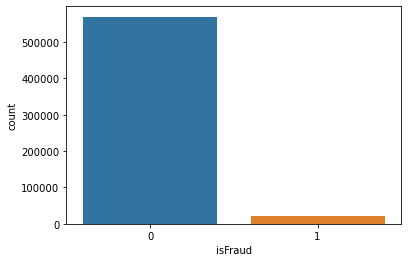

In [63]:
#Plotting the target variable

sns.countplot(x = train_df['isFraud'])
plt.show()

Let's look at this class imbalance in numbers.

In [64]:
train_df['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [65]:
percentage_1 = train_df[train_df['isFraud']==1].shape[0]*100/train_df.shape[0]
print("Percentage of values in the target variable that are one: " + str(round(percentage_1, 3)) + "%")

Percentage of values in the target variable that are one: 3.499%


There's a huge class imbalance in this variable. This will have to be accounted for while building models.

#### Let's look at the TransactionDT column

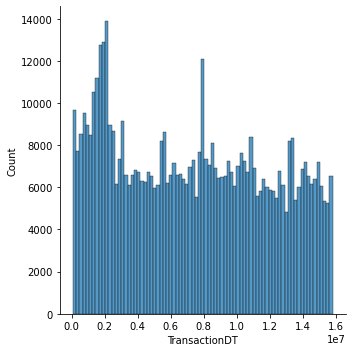

In [66]:
sns.displot(train_df['TransactionDT'])
plt.show()

Since this column is the timedelta from a given reference datetime, and it is given in seconds, we can convert the seconds to days and hours.

In [67]:
train_df['TransactionDT'][150000]

3093457

In [68]:
#Creating a new column for transaction day

train_df['TransactionDay'] = (train_df['TransactionDT']//(24*60*60))%7

In [69]:
#Specifying a lambda function to use an estimator

percentage = lambda x: float(len(x))/len(train_df['TransactionDay'])*100

In [70]:
#Setting the seaborn color palette

sns.set_palette('Paired')

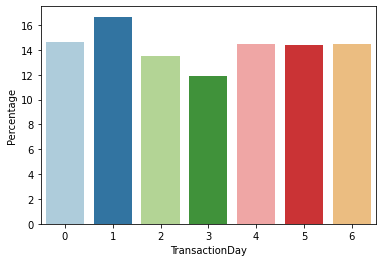

In [71]:
#Checking the percentage of transactions that occur on each day of the week
ax = sns.barplot(x = train_df['TransactionDay'], y = train_df['TransactionDay'], estimator = percentage)
ax.set(ylabel='Percentage')
plt.show()

Day 1 has the most transactions, whereas Day 3 has the lowest. This variable needs to be treated as a categorical variable (nominal data).


Let's check the percentage of fraud committed on each day.

In [72]:
#Creating a group by object
train_group_day = train_df.groupby(['isFraud'])

In [73]:
#Normalizing the value counts so that the isFraud=0 values are also visible (the class imbalance makes plots of those values
# very small). Also multiplying by 100, resetting the index, and sorting by the days of the week

train_group_day = train_group_day['TransactionDay'].value_counts(normalize=True).rename('Percentage').mul(100).reset_index().sort_values('TransactionDay')
train_group_day

,isFraud,TransactionDay,Percentage
1,0,0,14.593675
8,1,0,15.539854
0,0,1,16.661841
7,1,1,17.180468
5,0,2,13.489051
9,1,2,14.339641
6,0,3,11.883266
13,1,3,12.113439
2,0,4,14.519975
12,1,4,13.003920


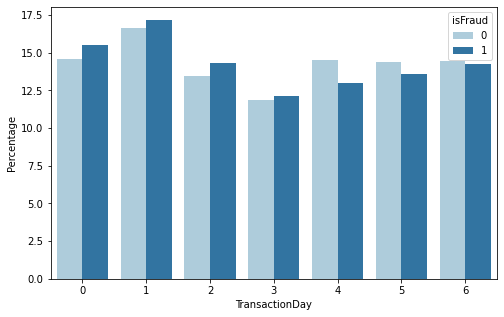

In [74]:
plt.figure(figsize=(8, 5))
sns.barplot(x='TransactionDay', y='Percentage', hue='isFraud', data=train_group_day)
plt.show()

The percentage of fraud committed is relatively higher on days 0 to 3, and lower on the rest of the days.

In [75]:
#Creating a new column for transaction hour

train_df['TransactionHour'] = (train_df['TransactionDT']//(60*60))%24

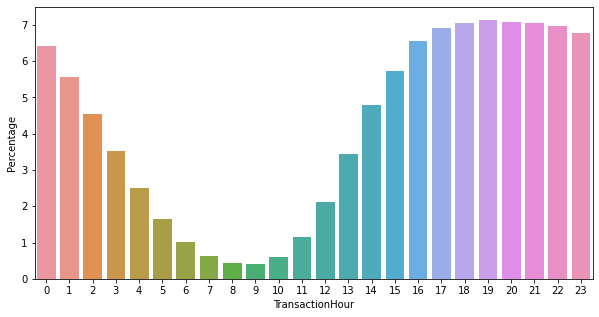

In [76]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = train_df['TransactionHour'], y = train_df['TransactionHour'], estimator = percentage)
ax.set(ylabel='Percentage')
plt.show()

Very few transactions occur between the hours 4 and 12.

In [77]:
#Creating a group by object
train_group_hour = train_df.groupby(['isFraud'])

In [78]:
#Similar operations as before

train_group_hour = train_group_hour['TransactionHour'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index().sort_values('TransactionHour')
train_group_hour

,isFraud,TransactionHour,Percentage
8,0,0,6.424018
31,1,0,5.739728
33,1,1,4.970237
10,0,1,5.574887
34,1,2,4.849247
12,0,2,4.515009
13,0,3,3.510407
36,1,3,3.857136
15,0,4,2.468778
37,1,4,3.726468


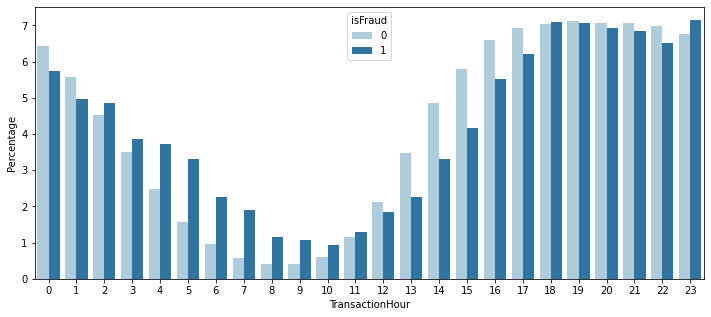

In [79]:
plt.figure(figsize=(12, 5))
sns.barplot(x='TransactionHour', y='Percentage', hue='isFraud', data=train_group_hour)
plt.show()

In [80]:
#We can drop the 'TransactionDT' column as it's no longer required

train_df = train_df.drop(['TransactionDT'], axis=1)

Let's create a new column that categorizes the transaction hour as high, medium, or low risk.

In [81]:
#Defining a function to bin transaction hour as low, medium, or high
def TransactionHour_Risk_Categorizer(hour):
    if (hour >= 4 and hour <=9):
        return "low"
    elif (hour >= 12 and hour <= 17) or (hour == 0 or hour == 1 or hour == 22):
        return "high"
    else:
        return "medium"

In [82]:
#Applying the function and creating a new column to store the categories
train_df['TransactionHour_Risk'] = train_df['TransactionHour'].apply(TransactionHour_Risk_Categorizer)
train_df['TransactionHour_Risk'].value_counts()

high      286105
medium    265114
low        39321
Name: TransactionHour_Risk, dtype: int64

In [83]:
#We can drop the 'TransactionHour' column as it's no longer required

train_df = train_df.drop(['TransactionHour'], axis=1)

In [84]:
#Adding the two new columns to the list of categorical columns (they should be treated as categorical columns)

categorical_columns.append('TransactionDay')
categorical_columns.append('TransactionHour_Risk')
categorical_columns

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'M6',
 'TransactionDay',
 'TransactionHour_Risk']

In [85]:
#Deleting variables that are no longer required

del train_group_hour, train_group_day

In [86]:
#Triggering garbage collection

gc.collect()

22932

#### Repeating the steps related to the TransactionDT column in the test set

In [87]:
#Creating a new column for transaction day

test_df['TransactionDay'] = (test_df['TransactionDT']//(24*60*60))%7

In [88]:
#Creating a new column for transaction hour

test_df['TransactionHour'] = (test_df['TransactionDT']//(60*60))%24

In [89]:
#We can drop the 'TransactionDT' column as it's no longer required

test_df = test_df.drop(['TransactionDT'], axis=1)

In [90]:
#Creating a new column that categorizes the transaction hour as high, medium, or low risk
test_df['TransactionHour_Risk'] = test_df['TransactionHour'].apply(TransactionHour_Risk_Categorizer)
test_df['TransactionHour_Risk'].value_counts()

high      248724
medium    225233
low        32734
Name: TransactionHour_Risk, dtype: int64

In [91]:
#We can drop the 'TransactionHour' column as it's no longer required

test_df = test_df.drop(['TransactionHour'], axis=1)

#### Let's look at the TransactionAMT column

In [92]:
train_df['TransactionAmt'].describe()

count    590540.000000
mean               NaN
std                NaN
min           0.250977
25%          43.312500
50%          68.750000
75%         125.000000
max       31936.000000
Name: TransactionAmt, dtype: float64

There's a big jump from the 75th percentile to the max value. Let's take a closer look.

In [93]:
print("95 percentile: {} \n99 percentile: {} \n99.5 percentile: {} \n99.9 percentile: {:,.2f}" .format(
    train_df['TransactionAmt'].quantile(0.95), train_df['TransactionAmt'].quantile(0.99), 
    train_df['TransactionAmt'].quantile(0.995), train_df['TransactionAmt'].quantile(0.999)))

95 percentile: 445.0 
99 percentile: 1104.0 
99.5 percentile: 1656.0 
99.9 percentile: 2,768.92


Since the values of the 99.9 percentile indicate that there are outliers in this column, let's check for outliers in the other variables too.

### i. Outlier Treatment

In [94]:
#Adding percentiles to the describe() function

train_df.describe(percentiles=[.25, .5, .75, .95, .99, .995, .999, .9995])

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,TransactionDay
count,590540.000000,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,590540.0,590540.0,590540.000000,590540.000,590540.0,590540.000,590540.000,590540.0,590540.0,590540.0,590540.000,590540.000,590540.0,590540.000,589271.0,421618.0,514518.0,501427.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.000000,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.000,501376.0,501376.0,501376.0,501376.0,501376.0,501376.000000,501376.0,501376.0,501376.0,501376.0,501376.0,590226.0,590226.0,590226.0,590226.000000,590226.0,590226.000000,590226.00,590226.0,590226.0,590226.000000,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.000000,590226.000000,590226.000000,590226.0,590226.0,590226.0,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590528.0,590528.0,589271.000000,589271.0,589271.0,590528.000000,590528.0,590528.000000,590528.0,589271.0,589271.0,590528.0,590528.0,590528.0,590528.0,590528.0,590528.0,589271.0,590528.000000,590528.0,590528.0,589271.000000,589271.000000,590528.0,590528.0,590528.0,590528.0,590528.000000,590528.000000,590528.000000,590528.0,590528.0000,590528.0,590528.000,589271.0000,589271.0,589271.0,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590540.000000
mean,0.034990,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122375,0.123352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000775,0.000830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061920,NaN,NaN,NaN,NaN,NaN,0.085327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.976227,336.539764,204.077377,NaN,NaN,NaN,103.512779,204.886200,145.971436,17.250622,38.821007,26.365685,NaN,NaN,0.087708,NaN,NaN,0.088745,NaN,0.031494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.089111,NaN,NaN,0.045471,0.052002,NaN,NaN,NaN,NaN,139.743408,408.579376,230.389160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.817917,247.600327,162.151230,18.372953,42.073849,28.327173,2.957940
std,0.183755,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.150635,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

From the percentile values, it looks like capping these columns at 99.5% will not be enough (I tried dropping all rows where one of the columns was 99.95% or higher, and this removed more than 50% of the rows). 

Let's look at the distributions of some of the columns with outliers.

In [95]:
#Setting the seaborn color palette to default

sns.set()

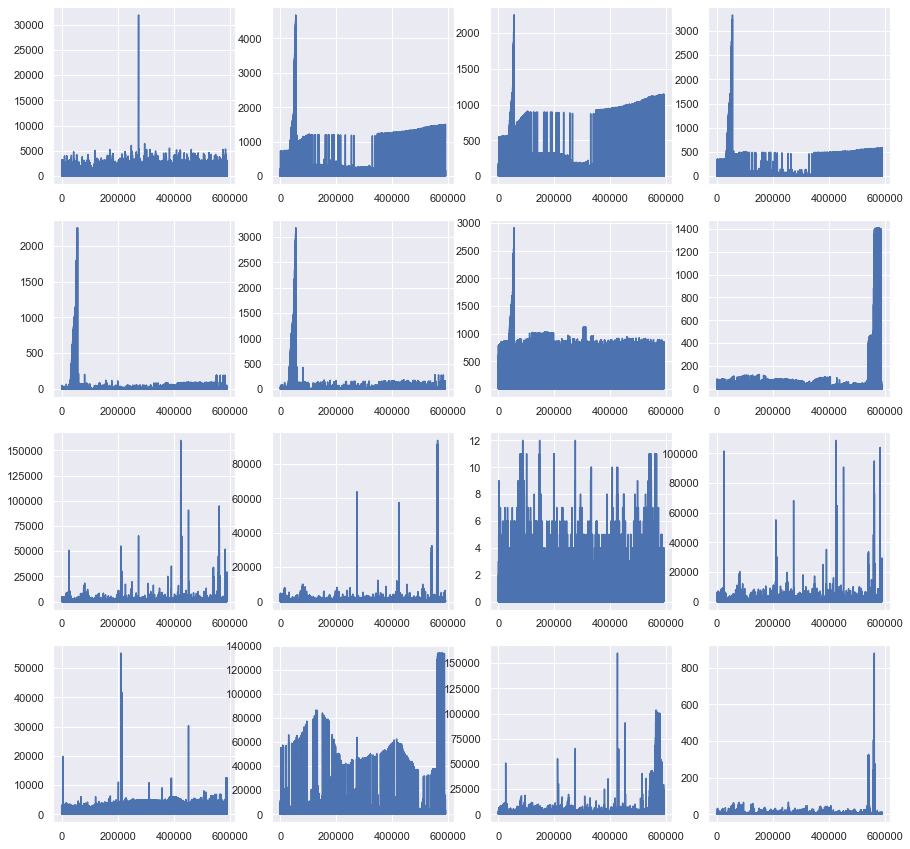

In [96]:
fig, a =  plt.subplots(4,4, figsize=(15,15))

a[0][0].plot(train_df.index, train_df['TransactionAmt'])
a[0][1].plot(train_df.index, train_df['C1'])
a[0][2].plot(train_df.index, train_df['C6'])
a[0][3].plot(train_df.index, train_df['C8'])

a[1][0].plot(train_df.index, train_df['C7'])
a[1][1].plot(train_df.index, train_df['C12'])
a[1][2].plot(train_df.index, train_df['C13'])
a[1][3].plot(train_df.index, train_df['V96'])

a[2][0].plot(train_df.index, train_df['V126'])
a[2][1].plot(train_df.index, train_df['V132'])
a[2][2].plot(train_df.index, train_df['V297'])
a[2][3].plot(train_df.index, train_df['V306'])

a[3][0].plot(train_df.index, train_df['V310'])
a[3][1].plot(train_df.index, train_df['V317'])
a[3][2].plot(train_df.index, train_df['V128'])
a[3][3].plot(train_df.index, train_df['V279'])


plt.show()

These variables are skewed and/or have tall spikes in between. Applying a transformation will be better.

In [97]:
#Creating a backup of the dataframe

train_df_backup = train_df.copy()

In [98]:
#Triggering garbage collection

gc.collect()

9101

### Outlier treatment - log transformation

In [99]:
#Creating a list of columns that are to be transformed

cols_transform = ['TransactionAmt', 'card1', 'C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14', 
                    'V95', 'V96', 'V97', 'V101', 'V102', 'V103', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 
                    'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V291', 'V292', 'V293', 'V294', 'V295', 'V306', 
                    'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 
                    'V320', 'V321']

In [100]:
#Creating a function to check if there are columns that do not contain any zeros 

def check_col_zeros(df):
    for col in df.columns:
        cols_non_zero = []
        if not (df[col]==0).any():
            cols_non_zero.append(str(col))
    return cols_non_zero          
    

In [101]:
#Checking if the columns that we want to transform contain zero values

cols_log_transform = check_col_zeros(train_df[cols_transform])
len(cols_log_transform)

0

Since all of these columns contain zero values, we cannot use a log transformation directly (as we'll get negative infinity wherever there's a zero). Let's add a constant value before we apply the log function.

In [102]:
#Defining a function to apply log transformation

def log_transform(df, cols_to_transform):
    for col in df.columns:
        if col in cols_to_transform:
            df[col] = np.log(df[col]+1)                #This is to ensure that we don't get -ve inf values
    return df

In [103]:
train_df = log_transform(train_df, cols_transform)

In [104]:
#Let's look at the distribution of variables again

train_df.describe(percentiles=[.25, .5, .75, .95, .99, .995, .999, .9995])

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,TransactionDay
count,590540.000000,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.0,421618.0,514518.0,501427.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.000000,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.000,501376.0,501376.0,501376.0,501376.0,501376.0,501376.000000,501376.0,501376.0,501376.0,501376.0,501376.0,590226.000000,590226.000000,590226.000000,590226.000000,590226.0,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590528.000000,590528.000000,589271.000000,589271.0,589271.0,590528.000000,590528.0,590528.000000,590528.0,589271.0,589271.0,590528.0,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.0,590528.000000,590528.0,590528.0,589271.000000,589271.000000,590528.0,590528.0,590528.0,590528.0,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590540.000000
mean,0.034990,NaN,9.026290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122375,0.123352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000775,0.000830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061920,NaN,NaN,0.064636,NaN,0.088806,0.085327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.673945,1.990060,1.160394,NaN,NaN,NaN,0.297811,0.503035,0.384594,0.228441,0.367832,0.278245,NaN,NaN,0.087708,NaN,NaN,0.088745,NaN,0.031494,NaN,NaN,NaN,NaN,NaN,NaN,0.084595,NaN,NaN,NaN,0.089111,NaN,NaN,0.045471,0.052002,NaN,NaN,NaN,NaN,0.823605,2.442684,1.427412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.381876,0.656799,0.498714,0.237079,0.410182,0.300843,

The distribution looks much better. Also, we've got zeros instead of -inf as we've used log(x+1).

Let's look at some of the transformed columns.

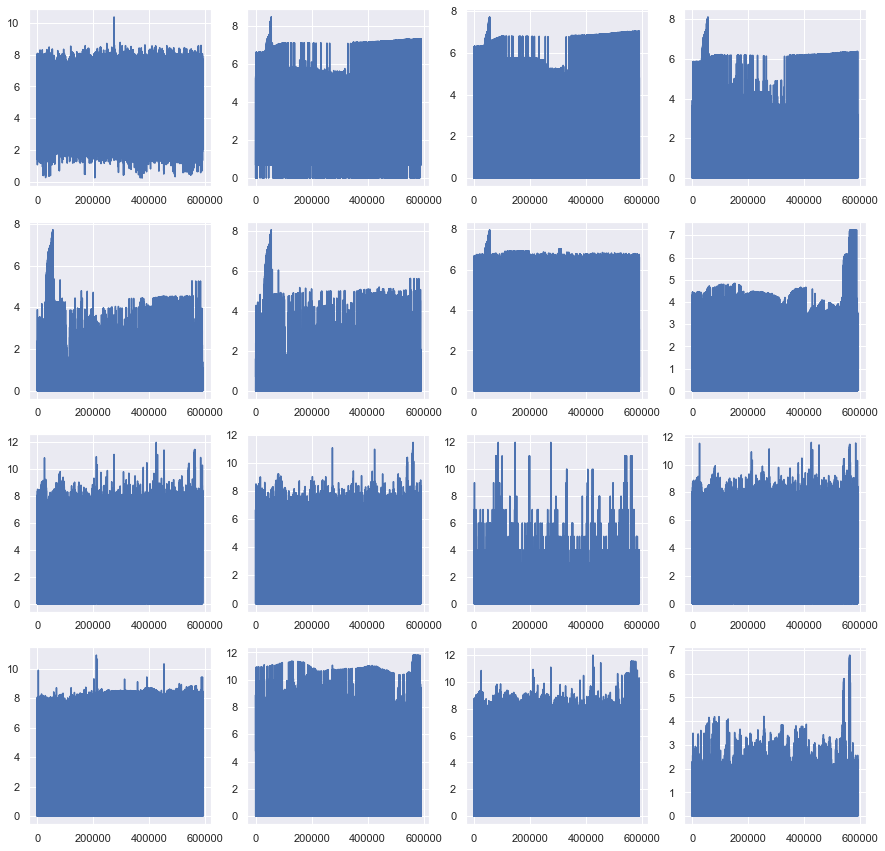

In [105]:
fig, a =  plt.subplots(4,4, figsize=(15,15))

a[0][0].plot(train_df.index, train_df['TransactionAmt'])
a[0][1].plot(train_df.index, train_df['C1'])
a[0][2].plot(train_df.index, train_df['C6'])
a[0][3].plot(train_df.index, train_df['C8'])

a[1][0].plot(train_df.index, train_df['C7'])
a[1][1].plot(train_df.index, train_df['C12'])
a[1][2].plot(train_df.index, train_df['C13'])
a[1][3].plot(train_df.index, train_df['V96'])

a[2][0].plot(train_df.index, train_df['V126'])
a[2][1].plot(train_df.index, train_df['V132'])
a[2][2].plot(train_df.index, train_df['V297'])
a[2][3].plot(train_df.index, train_df['V306'])

a[3][0].plot(train_df.index, train_df['V310'])
a[3][1].plot(train_df.index, train_df['V317'])
a[3][2].plot(train_df.index, train_df['V128'])
a[3][3].plot(train_df.index, train_df['V279'])


plt.show()

Most of the variables' distributions are better. Some of them still have spikes, but the difference in value between the spike and the trough is much lesser now.

In [106]:
#Deleting some variables that we no longer need

del cols_log_transform

In [107]:
#Triggering garbage collection

gc.collect()

37833

#### Repeating these steps for the test set

In [108]:
#Performing log transformation

test_df = log_transform(test_df, cols_transform)

#### Getting back to data exploration

Let's visualize the initial few variables: TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, and P_emaildomain.

In [109]:
#To visualize the ProductCD column, we need to use groupby (since we want the 0 and 1 values to be comparable)

ProductCD_group = (train_df.groupby(['isFraud'])['ProductCD'].value_counts(normalize=True).mul(100).rename('Percentage')
                            .reset_index().sort_values('ProductCD'))

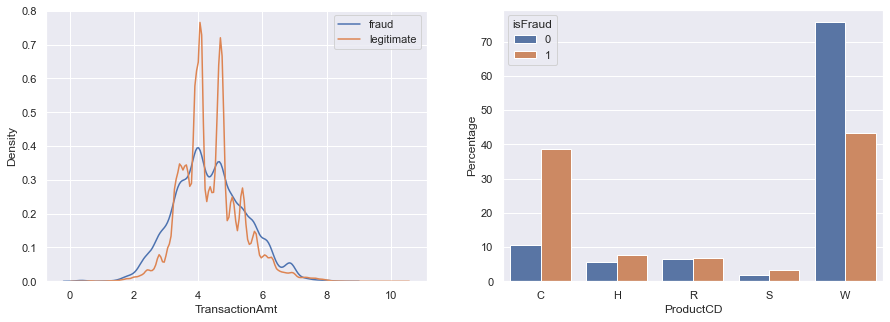

In [110]:
#Plotting the two variables
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['TransactionAmt'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['TransactionAmt'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
sns.barplot(x="ProductCD", y="Percentage", hue="isFraud", data=ProductCD_group)

plt.show()

In the TransactionAmt variable, the fraudulent transactions have a wider spread, and the legitimate transactions are more likely to be closer to the mid-value.

The ProductCD graph shows that the highest percentage of fraudulent transactions occur for product type 'C'.

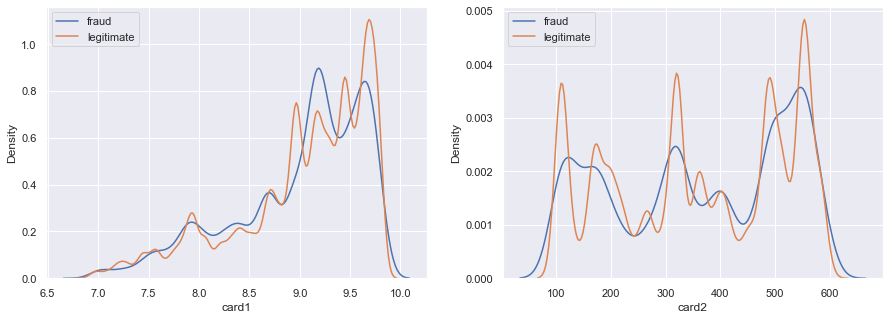

In [111]:
#Plotting the variables card1 and card2
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['card1'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['card1'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['isFraud']==1]['card2'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['card2'], hist=False)
plt.legend(['fraud','legitimate'])

plt.show()

card1 is skewed even after the log transformation. Both variables show a similar spread for fraudulent and legitimate transactions. However, the spikes in the card2 graph show that a lot of legitimate transactions are concentrated around certain values (105, 310, and 550).

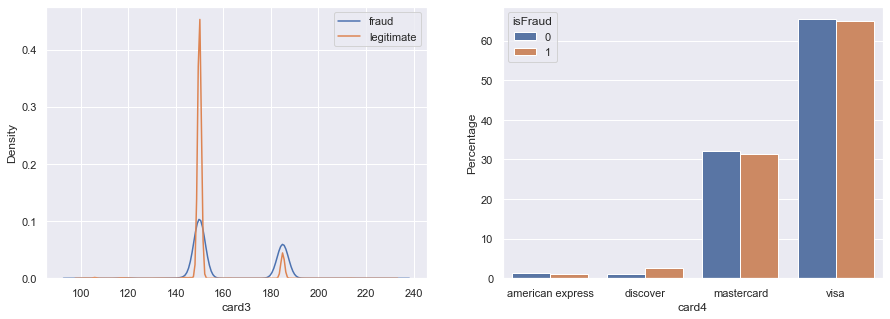

In [112]:
#Plotting the variables card3 and card4
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['card3'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['card3'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
card4_group = (train_df.groupby(['isFraud'])['card4'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()
                        .sort_values('card4'))
sns.barplot(x="card4", y="Percentage", hue="isFraud", data=card4_group)

plt.show()

card3 shows that the likelihood of fraudulent transactions increases with its value. card4 shows a fairly even percentage of fraudulent and legitimate transactions.

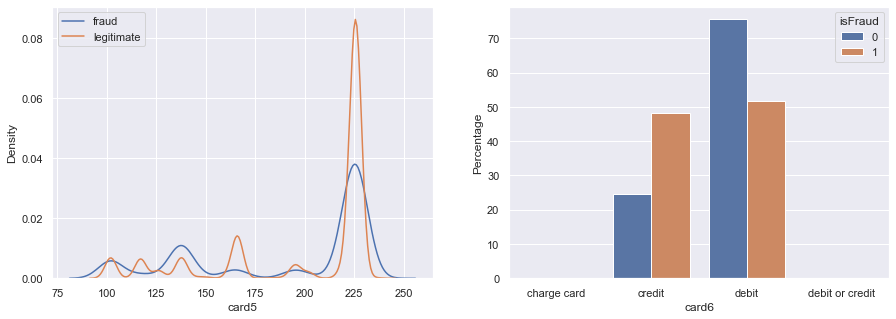

In [113]:
#Plotting the variables card5 and card6
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['card5'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['card5'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
card6_group = (train_df.groupby(['isFraud'])['card6'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()
                        .sort_values('card6'))
sns.barplot(x="card6", y="Percentage", hue="isFraud", data=card6_group)

plt.show()

card5 shows that legitimate transactions are more likely for higher values of this variable. We can also see that credit card transactions are more likely to be fraudulent than debit card transactions.

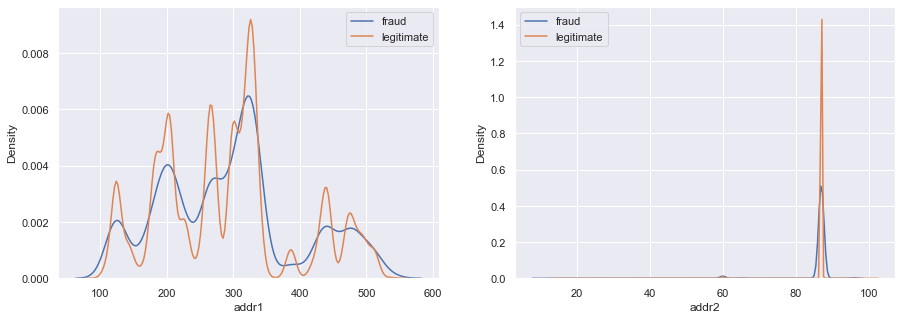

In [114]:
#Plotting the variables addr1 and addr2
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['addr1'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['addr1'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['isFraud']==1]['addr2'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['addr2'], hist=False)
plt.legend(['fraud','legitimate'])

plt.show()

addr1 and addr2 show similar distributions for legit and fraud transactions.

In [115]:
#Checking the number of categories in the p_emaildomain column
print("Number of unique values in the column: {}" .format(len(train_df['P_emaildomain'].unique())))
train_df['P_emaildomain'].value_counts()

Number of unique values in the column: 60


gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

Categories such as yahoo.com.mx and ymail can be merged with the category yahoo.

#### Merging categories in P_emaildomain column

In [116]:
# The next block does the same thing much more efficiently
# Leaving this code here to show how to apply a lambda function when a whole row is the input and we need to specify
# the columns of that row--useful if more than one column needs to be changed

# #Let's discard all characters from the first '.' to the end of the string in the email domains

# email_domain_col = train_df.apply(lambda row: re.sub("\..*$", '', str(row['P_emaildomain'])), axis=1)   #The str() is needed
# #as there are null values in the column and they throw errors when used as a regex pattern


In [117]:
#Let's discard all characters from the first '.' to the end of the string in the email domains

train_df['P_emaildomain'] = train_df['P_emaildomain'].apply(lambda x: re.sub("\..*$", '', str(x)))

In [118]:
#Also replacing 'ymail' with 'yahoo'

train_df['P_emaildomain'] = train_df['P_emaildomain'].apply(lambda x: 'yahoo' if x == 'ymail' else x)

In [119]:
#Viewing the first 25 rows of the P_emaildomain column

train_df['P_emaildomain'][:25]

0           nan
1         gmail
2       outlook
3         yahoo
4         gmail
5         gmail
6         yahoo
7          mail
8     anonymous
9         yahoo
10        gmail
11      hotmail
12      verizon
13          aol
14        yahoo
15          nan
16          aol
17        yahoo
18        gmail
19        gmail
20        gmail
21        gmail
22        gmail
23        gmail
24        gmail
Name: P_emaildomain, dtype: object

In [120]:
#Deleting the old backup dataframe

del train_df_backup

In [121]:
#Making a new backup of the dataframe
train_df_backup_2 = train_df.copy()

In [122]:
#Making the same change to the P_emaildomain column in the test set
test_df['P_emaildomain'] = test_df['P_emaildomain'].apply(lambda x: re.sub("\..*$", '', str(x)))

#Also replacing 'ymail' with 'yahoo' in the test set
test_df['P_emaildomain'] = test_df['P_emaildomain'].apply(lambda x: 'yahoo' if x == 'ymail' else x)

In [123]:
print("Number of email domains in the training set {}".format(len(set(train_df['P_emaildomain']))))
print("Number of email domains in the test set {}".format(len(set(test_df['P_emaildomain']))))

Number of email domains in the training set 44
Number of email domains in the test set 45


In [124]:
#Checking the email domain that's not present in the training set
set(test_df['P_emaildomain']) - set(train_df['P_emaildomain'])

{'scranton'}

In [125]:
#Let's check the number of times the domain name 'scranton' appears in the test set
test_df['P_emaildomain'].value_counts()

gmail           207945
yahoo            85338
nan              69192
hotmail          41409
anonymous        34064
aol              24048
comcast           6586
icloud            6049
outlook           5263
att               3614
live              3450
msn               3388
sbcglobal         2797
verizon           2306
bellsouth         1528
cox               1264
me                1191
optonline          926
charter            627
mail               597
earthlink          465
rocketmail         441
mac                426
frontier           314
netzero            280
roadrunner         278
web                278
juno               252
windstream         247
twc                209
embarqmail         204
frontiernet        202
centurylink        181
q                  173
aim                153
cableone           152
gmx                149
suddenlink         148
cfl                146
sc                 113
prodigy             96
protonmail          83
ptd                 72
servicios-t

In [126]:
#Checking the dimensions of the rows with this domain name
test_df[test_df['P_emaildomain'] == 'scranton'].shape

(2, 202)

In [127]:
#Comparing the dimensions of the train and test sets
print(train_df.shape)
print(test_df.shape)

(590540, 202)
(506691, 202)


The test set does not contain the 'isFraud' column. As a result, we don't have information on the target variable for the rows containing 'scranton.edu' in P_emaildomain. Therefore, let's drop these two rows.

In [128]:
test_df = test_df[test_df['P_emaildomain'] != 'scranton']
test_df.shape

(506689, 202)

Note: This is an advantage of performing operations on the test set alongside the train set. If this category had been discovered later by label encoder, it would not have been able to handle it.

In [129]:
#Triggering garbage collection

gc.collect()

33388

In [130]:
#Checking the number of unique values in the P_emaildomain column
len(train_df['P_emaildomain'].unique())

44

The number of categories has been reduced from 60 to 44.

#### Visualizing the P_emaildomain column

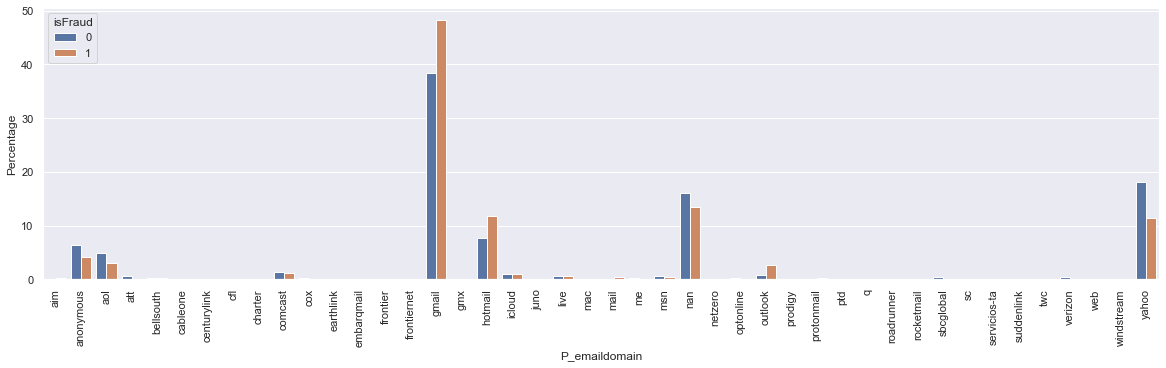

In [131]:
plt.figure(figsize=(20,5))

Email_group = (train_df.groupby(['isFraud'])['P_emaildomain'].value_counts(normalize=True).mul(100).rename('Percentage')
                       .reset_index().sort_values('P_emaildomain'))
sns.barplot(x="P_emaildomain", y="Percentage", hue="isFraud", data=Email_group)
plt.xticks(rotation=90)

plt.show()

Two of the most frequently used email domains - gmail and hotmail have a high percentage of fraud when compared to the others.

## Data Preparation for Modelling

In [132]:
#Let's look at the data types of all the columns

train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 202 columns):
 #   Column                Dtype  
---  ------                -----  
 0   isFraud               int8   
 1   TransactionAmt        float16
 2   ProductCD             object 
 3   card1                 float32
 4   card2                 float16
 5   card3                 float16
 6   card4                 object 
 7   card5                 float16
 8   card6                 object 
 9   addr1                 float16
 10  addr2                 float16
 11  P_emaildomain         object 
 12  C1                    float16
 13  C2                    float16
 14  C3                    float16
 15  C4                    float16
 16  C5                    float16
 17  C6                    float16
 18  C7                    float16
 19  C8                    float16
 20  C9                    float16
 21  C10                   float16
 22  C11                   float16
 23  C12     

LGBM accepts categorical columns but not string columns. Let's convert the string columns into category columns.

In [133]:
categorical_columns

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'M6',
 'TransactionDay',
 'TransactionHour_Risk']

In [134]:
#Converting the string columns into category columns in both the train and test sets

for i in categorical_columns:
    train_df[i] = train_df[i].astype('category')
    test_df[i] = test_df[i].astype('category')

In [135]:
#Let's look at the data types of all the columns

train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 202 columns):
 #   Column                Dtype   
---  ------                -----   
 0   isFraud               int8    
 1   TransactionAmt        float16 
 2   ProductCD             category
 3   card1                 float32 
 4   card2                 float16 
 5   card3                 float16 
 6   card4                 category
 7   card5                 float16 
 8   card6                 category
 9   addr1                 float16 
 10  addr2                 float16 
 11  P_emaildomain         category
 12  C1                    float16 
 13  C2                    float16 
 14  C3                    float16 
 15  C4                    float16 
 16  C5                    float16 
 17  C6                    float16 
 18  C7                    float16 
 19  C8                    float16 
 20  C9                    float16 
 21  C10                   float16 
 22  C11                

### Splitting the dataframe into train and validation sets

In [136]:
#Splitting the data 70-30

X_train_lgb, X_val_lgb = train_test_split(train_df, train_size = 0.75, random_state = 100)

In [137]:
y_train_lgb = X_train_lgb['isFraud']
y_val_lgb = X_val_lgb['isFraud']
X_train_lgb = X_train_lgb.drop(['isFraud'], axis=1)
X_val_lgb = X_val_lgb.drop(['isFraud'], axis=1)

In [138]:
print(y_train_lgb.shape, type(y_train_lgb))
print(y_val_lgb.shape, type(y_val_lgb))
print(X_train_lgb.shape, type(X_train_lgb))
print(X_val_lgb.shape, type(X_val_lgb))

(442905,) <class 'pandas.core.series.Series'>
(147635,) <class 'pandas.core.series.Series'>
(442905, 201) <class 'pandas.core.frame.DataFrame'>
(147635, 201) <class 'pandas.core.frame.DataFrame'>


In [139]:
y_train_lgb = np.array(y_train_lgb)           #This is because GridSearch requires X to be a df or a np array, and y must be a numpy array of shape (n,)
y_val_lgb = np.array(y_val_lgb)
print(y_train_lgb.shape)

(442905,)


Before we start modelling, let's delete all the variables that are no longer needed.

In [140]:
#Checking the current user-defined variables

%who

Email_group	 GridSearchCV	 LGBMClassifier	 ProductCD_group	 StratifiedKFold	 TransactionHour_Risk_Categorizer	 X_train_lgb	 X_val_lgb	 a	 
accuracy_score	 ax	 card4_group	 card6_group	 categorical_columns	 check_col_zeros	 classification_report	 cols_to_retain	 cols_transform	 
confusion_matrix	 cross_val_score	 dropped_columns	 elapsed_time	 fig	 float_int_memory_reducer	 gc	 i	 lgb	 
log_transform	 missing_values_df	 np	 path	 pd	 percentage	 percentage_1	 plt	 re	 
roc_auc_score	 sns	 start_process_time	 test_df	 time	 train_df	 train_df_backup_2	 train_test_split	 warnings	 
y_train_lgb	 y_val_lgb	 


In [141]:
#Let's delete all the unnecessary variables

del (Email_group, ProductCD_group, a, ax, card4_group, card6_group, cols_to_retain, cols_transform, dropped_columns,      
     fig, missing_values_df, percentage, percentage_1, train_df_backup_2)

In [142]:
#Triggering garbage collection

gc.collect()

63954

Since LGBM is a tree-type classifier, we don't need to perform feature scaling. Let's proceed to the model building phase.

## Modelling using Light Gradient Boosting Machine

#### Hyperparameters: num_leaves and max_depth

LGBM parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [143]:
#Specifying the hyperparameters to tune

param_grid = { 'num_leaves': [32, 64, 128, 192, 224],                 #Max number of leaves in one tree
               'max_depth': [6, 8, 12, 14, 16]                        #Max depth of tree model; -1 (default) indicates no limit
              }


#Specify the number of folds
n_folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)


# Instantiate the LGBM classifier
lgbm_grid = LGBMClassifier(random_state = 100, 
                bagging_seed = 100,               #Random seed for bagging
                objective = 'binary',             #Since we're performing binary classification
                boosting_type = 'gbdt',           #gbdt = gradient boosting decision tree algorithm (this is the default)
                metric = 'auc',                   #This is specified in the competition, and also since the data is unbalanced
                is_unbalance = True,              #To account for the imbalance in the target variables
                n_jobs = -1,                       
                #device_type = 'gpu'                #This option is also available, but it doesn't seem to work on Colab
                #categorical_feature = 'auto',     #Does this need to be specified??
                num_iterations = 100              #Number of boosting iterations (default = 100); we can change this once the hyperparameters have been tuned
               )


grid_search_lgbm_1 = GridSearchCV(estimator = lgbm_grid, param_grid = param_grid, cv = n_folds, verbose=1, n_jobs=-1)


# Fit the grid search to the data
grid_search_lgbm_1.fit(X_train_lgb, y_train_lgb)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  7.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LGBMClassifier(bagging_seed=100, is_unbalance=True,
                                      metric='auc', num_iterations=100,
                                      objective='binary', random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 12, 14, 16],
                         'num_leaves': [32, 64, 128, 192, 224]},
             verbose=1)

In [144]:
#Viewing the best parameters from the grid search
print(grid_search_lgbm_1.best_params_)
print(grid_search_lgbm_1.best_score_)

{'max_depth': 16, 'num_leaves': 224}
0.9478488614939998


Let's try fitting a few variations of the LGBM model with max_depth=16 and varying the num_leaves parameter

In [145]:
#Using the parameters provided by the grid search

params = { 'num_leaves': 224,
           'max_depth' : 16,
           'random_state' : 100, 
           'bagging_seed' : 100,              
           'objective' : 'binary',             
           'boosting_type' : 'gbdt',           
           'metric' : 'auc',                   
           'is_unbalance' : True,              
           'n_jobs' : -1,                   
           'num_iterations' : 100                   
         }


#Creating datasets for fitting this model (as some parameters cannot be changed after constructing a dataset)
d_train = lgb.Dataset(X_train_lgb, y_train_lgb)
d_valid = lgb.Dataset(X_val_lgb, y_val_lgb)

model1 = lgb.train(params, d_train, valid_sets=[d_train, d_valid], verbose_eval=50)

[LightGBM] [Info] Number of positive: 15609, number of negative: 427296
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16670
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035242 -> initscore=-3.309629
[LightGBM] [Info] Start training from score -3.309629
[50]	training's auc: 0.981254	valid_1's auc: 0.948056
[100]	training's auc: 0.991661	valid_1's auc: 0.956256


In [146]:
#Reducing the number of leaves to 192

params = { 'num_leaves': 192,
           'max_depth' : 16,
           'random_state' : 100, 
           'bagging_seed' : 100,              
           'objective' : 'binary',             
           'boosting_type' : 'gbdt',           
           'metric' : 'auc',                   
           'is_unbalance' : True,              
           'n_jobs' : -1,                   
           'num_iterations' : 100                   
         }

#Creating datasets for fitting this model (as some parameters cannot be changed after constructing a dataset)
d_train = lgb.Dataset(X_train_lgb, y_train_lgb)
d_valid = lgb.Dataset(X_val_lgb, y_val_lgb)

model2 = lgb.train(params, d_train, valid_sets=[d_train, d_valid], verbose_eval=50)

[LightGBM] [Info] Number of positive: 15609, number of negative: 427296
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16670
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035242 -> initscore=-3.309629
[LightGBM] [Info] Start training from score -3.309629
[50]	training's auc: 0.978036	valid_1's auc: 0.947189
[100]	training's auc: 0.989647	valid_1's auc: 0.956275


In [147]:
#Trying number of leaves = 128
params = { 'num_leaves': 128,
           'max_depth' : 16,
           'random_state' : 100, 
           'bagging_seed' : 100,              
           'objective' : 'binary',             
           'boosting_type' : 'gbdt',           
           'metric' : 'auc',                   
           'is_unbalance' : True,              
           'n_jobs' : -1,                   
           'num_iterations' : 100                   
         }

#Creating datasets for fitting this model (as some parameters cannot be changed after constructing a dataset)
d_train = lgb.Dataset(X_train_lgb, y_train_lgb)
d_valid = lgb.Dataset(X_val_lgb, y_val_lgb)

model3 = lgb.train(params, d_train, valid_sets=[d_train, d_valid], verbose_eval=50)

[LightGBM] [Info] Number of positive: 15609, number of negative: 427296
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16670
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035242 -> initscore=-3.309629
[LightGBM] [Info] Start training from score -3.309629
[50]	training's auc: 0.967574	valid_1's auc: 0.941123
[100]	training's auc: 0.982727	valid_1's auc: 0.952666


The drop in validation auc is from 0.9563 for num_leaves = 224 to 0.9527 for num_leaves = 128. Let's use num_leaves = 224 as it's giving the best result so far on constructed data sets.

#### Hyperparameter: max_bin

In [148]:
#Tuning the next parameter: max_bin

param_grid = { 'num_leaves': [224],
               'max_depth': [16],
               'max_bin' : [100, 155, 255, 355]                       #Max number of bins that feature values will be bucketed in; default = 100
              }


#Specify the number of folds
n_folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)


# Instantiate the LGBM classifier
lgbm_grid = LGBMClassifier(random_state = 100, 
                bagging_seed = 100,               #Random seed for bagging
                objective = 'binary',             #Since we're performing binary classification
                boosting_type = 'gbdt',           #gbdt = gradient boosting decision tree algorithm (this is the default)
                metric = 'auc',                   #This is specified in the competition, and also since the data is unbalanced
                is_unbalance = True,              #To account for the imbalance in the target variables
                n_jobs = -1,                       
                #device_type = 'gpu'                #This option is also available, but it doesn't seem to work on Colab
                #categorical_feature = 'auto',     #Does this need to be specified??
                num_iterations = 100              #Number of boosting iterations (default = 100); we can change this once the hyperparameters have been tuned
               )


grid_search_lgbm_2 = GridSearchCV(estimator = lgbm_grid, param_grid = param_grid, cv = n_folds, verbose=1, n_jobs=-1)


# Fit the grid search to the data
grid_search_lgbm_2.fit(X_train_lgb, y_train_lgb)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  1.1min remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LGBMClassifier(bagging_seed=100, is_unbalance=True,
                                      metric='auc', num_iterations=100,
                                      objective='binary', random_state=100),
             n_jobs=-1,
             param_grid={'max_bin': [100, 155, 255, 355], 'max_depth': [16],
                         'num_leaves': [224]},
             verbose=1)

In [149]:
#Viewing the best parameters from the grid search
print(grid_search_lgbm_2.best_params_)
print(grid_search_lgbm_2.best_score_)

{'max_bin': 355, 'max_depth': 16, 'num_leaves': 224}
0.9479572368792406


In [150]:
#Fitting the model with the parameters given by the GridSearch
params = { 'num_leaves': 224,
           'max_depth' : 16,
           'max_bin': 355,
           'random_state' : 100, 
           'bagging_seed' : 100,              
           'objective' : 'binary',             
           'boosting_type' : 'gbdt',           
           'metric' : 'auc',                   
           'is_unbalance' : True,              
           'n_jobs' : -1,                   
           'num_iterations' : 100                   
         }


#Creating datasets for fitting this model (as some parameters cannot be changed after constructing a dataset)
d_train = lgb.Dataset(X_train_lgb, y_train_lgb)
d_valid = lgb.Dataset(X_val_lgb, y_val_lgb)

model4 = lgb.train(params, d_train, valid_sets=[d_train, d_valid], verbose_eval=50)

[LightGBM] [Info] Number of positive: 15609, number of negative: 427296
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20917
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035242 -> initscore=-3.309629
[LightGBM] [Info] Start training from score -3.309629
[50]	training's auc: 0.981374	valid_1's auc: 0.948353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's auc: 0.991371	valid_1's auc: 0.956787


In [151]:
#Using max_bin = 100, the default value
params = { 'num_leaves': 224,
           'max_depth' : 16,
           'max_bin': 100,
           'random_state' : 100, 
           'bagging_seed' : 100,              
           'objective' : 'binary',             
           'boosting_type' : 'gbdt',           
           'metric' : 'auc',                   
           'is_unbalance' : True,              
           'n_jobs' : -1,                   
           'num_iterations' : 100                   
         }


#Creating datasets for fitting this model (as some parameters cannot be changed after constructing a dataset)
d_train = lgb.Dataset(X_train_lgb, y_train_lgb)
d_valid = lgb.Dataset(X_val_lgb, y_val_lgb)

model5 = lgb.train(params, d_train, valid_sets=[d_train, d_valid], verbose_eval=50)

[LightGBM] [Info] Number of positive: 15609, number of negative: 427296
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7973
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035242 -> initscore=-3.309629
[LightGBM] [Info] Start training from score -3.309629
[50]	training's auc: 0.981065	valid_1's auc: 0.948884
[100]	training's auc: 0.991805	valid_1's auc: 0.957292


On the validation dataset, max_bin = 100 gives a better validation auc than the value suggested by gridsearch: max_bin = 355. This could be because gridsearch uses cross validation on the training set and we are checking performance on the validation set. This could also be because we are using a constructed dataset here, unlike in gridsearch. Since the size of the dataset used for cross validation is larger than the validation set and the two aucs are close (0.9577 vs 0.9572), let's stick to the parameters suggested by gridsearch.

#### Hyperparameter: feature_fraction

In [152]:
#Tuning the next parameter: feature_fraction

param_grid = { 'num_leaves': [224],
               'max_depth': [16],
               'max_bin' : [355],
               'feature_fraction': [0.6, 0.7, 0.8, 0.9, 1],              #Percentage of features selected for training each tree
              }


#Specify the number of folds
n_folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)


# Instantiate the LGBM classifier
lgbm_grid = LGBMClassifier(random_state = 100, 
                bagging_seed = 100,               #Random seed for bagging
                objective = 'binary',             #Since we're performing binary classification
                boosting_type = 'gbdt',           #gbdt = gradient boosting decision tree algorithm (this is the default)
                metric = 'auc',                   #This is specified in the competition, and also since the data is unbalanced
                is_unbalance = True,              #To account for the imbalance in the target variables
                n_jobs = -1,                       
                #device_type = 'gpu'                #This option is also available, but it doesn't seem to work on Colab
                #categorical_feature = 'auto',     #Does this need to be specified??
                num_iterations = 100              #Number of boosting iterations (default = 100); we can change this once the hyperparameters have been tuned
               )


grid_search_lgbm_3 = GridSearchCV(estimator = lgbm_grid, param_grid = param_grid, cv = n_folds, verbose=1, n_jobs=-1)


# Fit the grid search to the data
grid_search_lgbm_3.fit(X_train_lgb, y_train_lgb)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.4min finished


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LGBMClassifier(bagging_seed=100, is_unbalance=True,
                                      metric='auc', num_iterations=100,
                                      objective='binary', random_state=100),
             n_jobs=-1,
             param_grid={'feature_fraction': [0.6, 0.7, 0.8, 0.9, 1],
                         'max_bin': [355], 'max_depth': [16],
                         'num_leaves': [224]},
             verbose=1)

In [153]:
#Viewing the best parameters from the grid search
print(grid_search_lgbm_3.best_params_)
print(grid_search_lgbm_3.best_score_)

{'feature_fraction': 1, 'max_bin': 355, 'max_depth': 16, 'num_leaves': 224}
0.9479572368792406


In [154]:
#Using feature_fraction = 1

params = { 'num_leaves': 224,
           'max_depth' : 16,
           'max_bin': 355,
           'feature_fraction' : 1,
           'random_state' : 100, 
           'bagging_seed' : 100,              
           'objective' : 'binary',             
           'boosting_type' : 'gbdt',           
           'metric' : 'auc',                   
           'is_unbalance' : True,              
           'n_jobs' : -1,                   
           'num_iterations' : 100                   
         }


#Creating datasets for fitting this model (as some parameters cannot be changed after constructing a dataset)
d_train = lgb.Dataset(X_train_lgb, y_train_lgb)
d_valid = lgb.Dataset(X_val_lgb, y_val_lgb)

model6 = lgb.train(params, d_train, valid_sets=[d_train, d_valid], verbose_eval=50)

[LightGBM] [Info] Number of positive: 15609, number of negative: 427296
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20917
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035242 -> initscore=-3.309629
[LightGBM] [Info] Start training from score -3.309629
[50]	training's auc: 0.981374	valid_1's auc: 0.948353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's auc: 0.991371	valid_1's auc: 0.956787


This is the same validation auc that we got when we tuned the previous variable. This is because the default value of feature_fraction is 1. Let's use this default value.

#### Hyperparameter: bagging_fraction

In [155]:
#Tuning the next parameter: bagging_fraction

param_grid = { 'num_leaves': [224],
               'max_depth': [16],
               'max_bin' : [355],
               'feature_fraction' : [1],
               'bagging_fraction': [0.5, 0.6, 0.7, 0.8, 0.9, 1],            
              }


#Specify the number of folds
n_folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)


# Instantiate the LGBM classifier
lgbm_grid = LGBMClassifier(random_state = 100, 
                bagging_seed = 100,               #Random seed for bagging
                objective = 'binary',             #Since we're performing binary classification
                boosting_type = 'gbdt',           #gbdt = gradient boosting decision tree algorithm (this is the default)
                metric = 'auc',                   #This is specified in the competition, and also since the data is unbalanced
                is_unbalance = True,              #To account for the imbalance in the target variables
                n_jobs = -1,                       
                #device_type = 'gpu'               #This option is also available, but it doesn't seem to work on Colab
                #categorical_feature = 'auto',     #Does this need to be specified??
                num_iterations = 100              #Number of boosting iterations (default = 100); we can change this once the hyperparameters have been tuned
               )


grid_search_lgbm_4 = GridSearchCV(estimator = lgbm_grid, param_grid = param_grid, cv = n_folds, verbose=1, n_jobs=-1)


# Fit the grid search to the data
grid_search_lgbm_4.fit(X_train_lgb, y_train_lgb)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LGBMClassifier(bagging_seed=100, is_unbalance=True,
                                      metric='auc', num_iterations=100,
                                      objective='binary', random_state=100),
             n_jobs=-1,
             param_grid={'bagging_fraction': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
                         'feature_fraction': [1], 'max_bin': [355],
                         'max_depth': [16], 'num_leaves': [224]},
             verbose=1)

In [156]:
#Viewing the best parameters from the grid search
print(grid_search_lgbm_4.best_params_)
print(grid_search_lgbm_4.best_score_)

{'bagging_fraction': 0.8, 'feature_fraction': 1, 'max_bin': 355, 'max_depth': 16, 'num_leaves': 224}
0.9479572368792406


In [157]:
#Using bagging_fraction = 0.5

params = { 'num_leaves': 224,
           'max_depth' : 16,
           'max_bin': 355,
           'feature_fraction' : 1,
           'bagging_fraction' : 0.5,
           'random_state' : 100, 
           'bagging_seed' : 100,              
           'objective' : 'binary',             
           'boosting_type' : 'gbdt',           
           'metric' : 'auc',                   
           'is_unbalance' : True,              
           'n_jobs' : -1,                   
           'num_iterations' : 100                   
         }


#Creating datasets for fitting this model (as some parameters cannot be changed after constructing a dataset)
d_train = lgb.Dataset(X_train_lgb, y_train_lgb)
d_valid = lgb.Dataset(X_val_lgb, y_val_lgb)

model7 = lgb.train(params, d_train, valid_sets=[d_train, d_valid], verbose_eval=50)

[LightGBM] [Info] Number of positive: 15609, number of negative: 427296
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20917
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035242 -> initscore=-3.309629
[LightGBM] [Info] Start training from score -3.309629
[50]	training's auc: 0.981374	valid_1's auc: 0.948353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's auc: 0.991371	valid_1's auc: 0.956787


This is the same validation auc that we had got before tuning bagging_fraction. Let's use bagging_fraction = 0.5.

#### Hyperparameters: lambda_l1 and lambda_l2

In [158]:
#Tuning the next parameters: lambda_l1 and lambda_l2

param_grid = { 'num_leaves': [224],
               'max_depth': [16],
               'max_bin' : [355],
               'feature_fraction' : [1],
               'bagging_fraction' : [0.5],
               'lambda_l1': [0, 0.01, 0.05, 0.1, 0.25],
               'lambda_l2' : [0, 0.01, 0.05, 0.1, 0.25]
              }


#Specify the number of folds
n_folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)


# Instantiate the LGBM classifier
lgbm_grid = LGBMClassifier(random_state = 100, 
                bagging_seed = 100,               #Random seed for bagging
                objective = 'binary',             #Since we're performing binary classification
                boosting_type = 'gbdt',           #gbdt = gradient boosting decision tree algorithm (this is the default)
                metric = 'auc',                   #This is specified in the competition, and also since the data is unbalanced
                is_unbalance = True,              #To account for the imbalance in the target variables
                n_jobs = -1,                       
                #device_type = 'gpu'               #This option is also available, but it doesn't seem to work on Colab
                #categorical_feature = 'auto',     #Does this need to be specified??
                num_iterations = 100              #Number of boosting iterations (default = 100); we can change this once the hyperparameters have been tuned
               )


grid_search_lgbm_5 = GridSearchCV(estimator = lgbm_grid, param_grid = param_grid, cv = n_folds, verbose=1, n_jobs=-1)


# Fit the grid search to the data
grid_search_lgbm_5.fit(X_train_lgb, y_train_lgb)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 10.6min finished


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LGBMClassifier(bagging_seed=100, is_unbalance=True,
                                      metric='auc', num_iterations=100,
                                      objective='binary', random_state=100),
             n_jobs=-1,
             param_grid={'bagging_fraction': [0.5], 'feature_fraction': [1],
                         'lambda_l1': [0, 0.01, 0.05, 0.1, 0.25],
                         'lambda_l2': [0, 0.01, 0.05, 0.1, 0.25],
                         'max_bin': [355], 'max_depth': [16],
                         'num_leaves': [224]},
             verbose=1)

In [159]:
#Viewing the best parameters from the grid search
print(grid_search_lgbm_5.best_params_)
print(grid_search_lgbm_5.best_score_)

{'bagging_fraction': 0.5, 'feature_fraction': 1, 'lambda_l1': 0.25, 'lambda_l2': 0.1, 'max_bin': 355, 'max_depth': 16, 'num_leaves': 224}
0.9486932863706663


In [160]:
#Using lambda_l1 = 0.01 and lambda_l2 = 0.1

params = { 'num_leaves': 224,
           'max_depth' : 16,
           'max_bin': 355,
           'feature_fraction' : 1,
           'bagging_fraction' : 0.5,
           'lambda_l1': 0.01,
           'lambda_l2': 0.1,
           'random_state' : 100, 
           'bagging_seed' : 100,              
           'objective' : 'binary',             
           'boosting_type' : 'gbdt',           
           'metric' : 'auc',                   
           'is_unbalance' : True,              
           'n_jobs' : -1,                   
           'num_iterations' : 100                   
         }


#Creating datasets for fitting this model (as some parameters cannot be changed after constructing a dataset)
d_train = lgb.Dataset(X_train_lgb, y_train_lgb)
d_valid = lgb.Dataset(X_val_lgb, y_val_lgb)

model8 = lgb.train(params, d_train, valid_sets=[d_train, d_valid], verbose_eval=50)

[LightGBM] [Info] Number of positive: 15609, number of negative: 427296
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20917
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035242 -> initscore=-3.309629
[LightGBM] [Info] Start training from score -3.309629
[50]	training's auc: 0.981126	valid_1's auc: 0.948209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's auc: 0.991773	valid_1's auc: 0.956153


Sticking with the tuned l1 and l2 values, even though the validation auc has gone down (as the dataset used in 5-fold cross validation is larger than the validation set)

### Fitting the final model

In [161]:
#Using the tuned hyperparameters for fitting the model

params = { 'num_leaves': 224,
           'max_depth' : 16,
           'max_bin': 355,
           'feature_fraction' : 1,
           'bagging_fraction' : 0.5,
           'lambda_l1': 0.01,
           'lambda_l2': 0.1,
           'random_state' : 100, 
           'bagging_seed' : 100,              
           'objective' : 'binary',             
           'boosting_type' : 'gbdt',           
           'metric' : 'auc',                   
           'is_unbalance' : True,              
           'n_jobs' : -1,                   
           'num_iterations' : 100                   
         }


#Creating datasets for fitting this model (as some parameters cannot be changed after constructing a dataset)
d_train = lgb.Dataset(X_train_lgb, y_train_lgb)
d_valid = lgb.Dataset(X_val_lgb, y_val_lgb)

model_tuned_1 = lgb.train(params, d_train, valid_sets=[d_train, d_valid], verbose_eval=50)

[LightGBM] [Info] Number of positive: 15609, number of negative: 427296
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20917
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035242 -> initscore=-3.309629
[LightGBM] [Info] Start training from score -3.309629
[50]	training's auc: 0.981126	valid_1's auc: 0.948209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's auc: 0.991773	valid_1's auc: 0.956153


This (0.95697) is the highest validation auc that we've got so far.

### Let's take a look at the most important features in the LGBM model

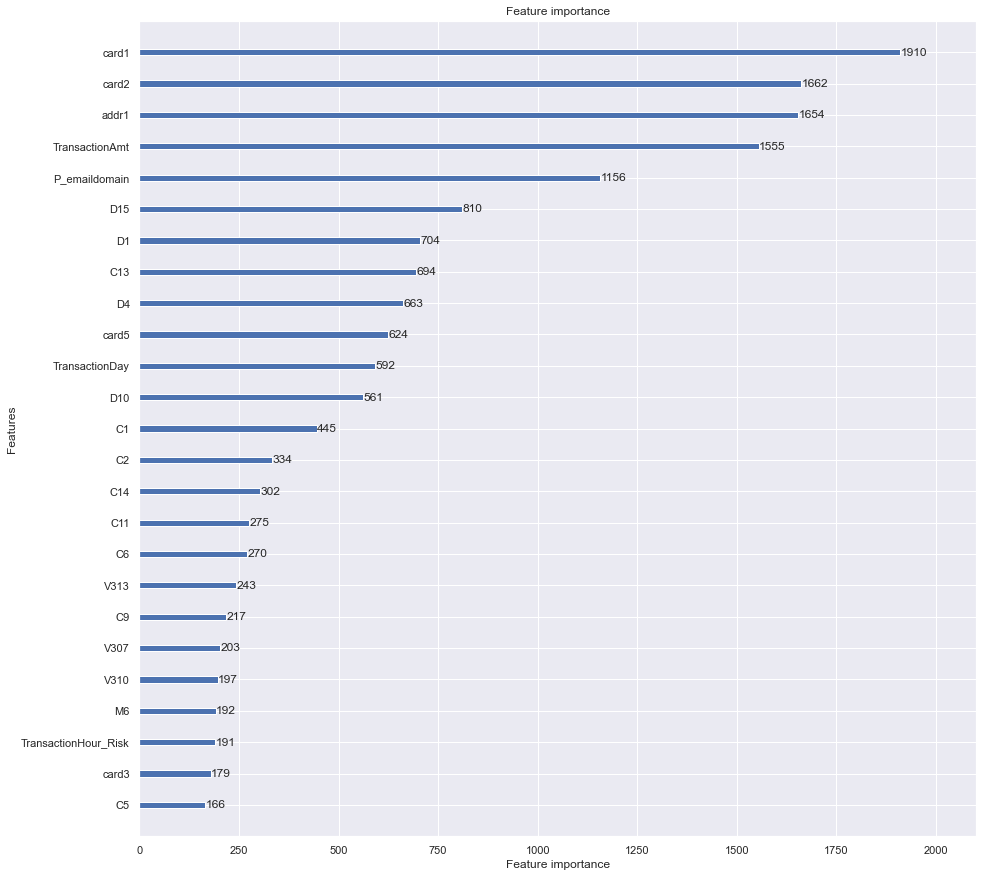

In [162]:
ax = lgb.plot_importance(model_tuned_1, max_num_features=25, figsize=(15,15))
plt.show()

card1 and card2 are the most important features. A lot of the C and D variables are also present in the top 25 most important features.

### Making Predictions on the test set

In [163]:
#Storing the predictions in a dictionary

data = {'TransactionID': test_df['TransactionID'], 
        'isFraud': model_tuned_1.predict(test_df.drop('TransactionID', axis=1))         #Excluding the TransactionID column as it's not a part of the train set
        }

In [164]:
#Converting the dictionary into a dataframe

test_predictions_df = pd.DataFrame(data)
test_predictions_df.head()

,TransactionID,isFraud
0,3663549,0.244797
1,3663550,0.067933
2,3663551,0.076235
3,3663552,0.050155
4,3663553,0.001413


The predictions are probabilities, as required.

In [165]:
#Exporting the dataframe to a csv file
test_predictions_df.to_csv('predictions_for_submission.csv')